In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from functools import partial
from copy import deepcopy
from toolz import compose, valmap, keyfilter, identity, merge
from itertools import combinations
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

import sbi
import sbi.utils
import sbi.inference
import sbi.analysis

import sbibm
import sbibm.tasks.eggbox

import scipy
import scipy.stats

import swyft
import swyft.utils.constrainedcorner as cc

import tmnre
import tmnre.metrics
import tmnre.benchmark
import tmnre.coverage.oned
from tmnre.nn.resnet import make_resenet_tail
from tmnre.marginalize import filter_marginals_by_dim

import corner

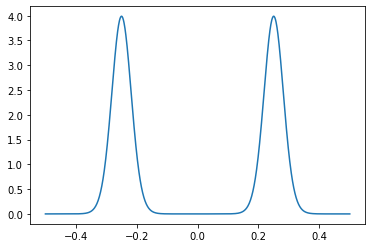

In [25]:
sigma = 0.1

def get_indicator_function(lower_x: float, upper_x: float, fn = identity):
    return lambda xx: np.where((lower_x <= xx) & (xx <= upper_x), fn(xx), np.zeros_like(xx))

def g(theta): 
    return np.sin(np.pi * theta - np.pi/2) ** 2

def get_unnormalized_posterior_pdf(x: float, sigma: float = 0.1) -> np.ndarray:
    normal_pdf = compose(np.exp, scipy.stats.norm(loc=x, scale=sigma).logpdf)
    return get_indicator_function(
        -0.5, 0.5, lambda theta: compose(normal_pdf, g)(theta)
    )

post_pdf = get_unnormalized_posterior_pdf(0.5)
x = np.linspace(-0.5, 0.5, 1000)
plt.plot(x, post_pdf(x))

# todo I think I can just generate samples in this configuration then transport them to where I want them

In [3]:
log = logging.getLogger()
log.setLevel(logging.INFO)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

np.random.seed(28);
torch.manual_seed(28);

In [4]:
TASK_NAME = "eggbox"
NUM_OBS = 1
DIM = 10
SEQDIM = 2
N_SIMULATIONS = 10_000
N_POSTERIOR_SAMPLES = 25_000
N_JOBS = 12

task = sbibm.get_task(
    TASK_NAME,
    dim=DIM,
)

theta0 = task.get_true_parameters(NUM_OBS).squeeze()
obs0 = task.get_observation(NUM_OBS).squeeze()
print(theta0)
print(obs0)

tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
        0.2500])
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000])


In [209]:
def rot(angle: float, rdim1: int, rdim2: int, dim: int):
    assert rdim1 != rdim2
    r = np.eye(dim)
    r[rdim1, rdim1] = np.cos(angle)
    r[rdim1, rdim2] = -np.sin(angle)
    r[rdim2, rdim1] = np.sin(angle)
    r[rdim2, rdim2] = np.cos(angle)
    return r

rot3 = partial(rot, dim=3)
rot4 = partial(rot, dim=4)
rot10 = partial(rot, dim=10)
rot3(np.pi/4, 0, 1)

array([[ 0.70710678, -0.70710678,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [86]:
ps = task.get_reference_posterior_samples(NUM_OBS).numpy()
print(ps.shape)

(10000, 10)


In [201]:
dim = 3

# set initial postitions
x = compose(np.tril, np.ones)((dim, dim)) * 2 - 1
# print(x)
# x = x / np.linalg.norm(x, axis=1)

# set rotated positions
b = np.eye(dim) * np.linalg.norm(x, axis=1)[0]

# determine rotation matrix
a = b @ np.linalg.inv(x)

# print(np.linalg.det(a))
# np.round(a)
# np.round(a, 5) @ x
a @ x

array([[1.73205081, 0.        , 0.        ],
       [0.        , 1.73205081, 0.        ],
       [0.        , 0.        , 1.73205081]])

In [207]:
np.linalg.det(b) * (1/np.linalg.det(x))

1.2990381056766578

In [177]:
R.from_matrix(a).as_euler("zyz", degrees=True)

array([-56.30993247,  31.00271913,  33.69006753])

In [187]:
v = np.asarray(
    [[1., 1., 1.,],
     [-1., 1., -1.],
    ]).T
# np.round(R.from_euler("zyz", [-np.pi/4, np.arctan(1/np.sqrt(2)), 0], ).as_matrix() @ v, 2)
np.round(R.from_euler("zyz", [np.pi/4, np.pi/4, np.pi/4], ).as_matrix() @ v, 2)

array([[-0.5 , -1.21],
       [ 1.5 , -1.21],
       [ 0.71,  0.29]])

In [138]:
from scipy.spatial.transform import Rotation as R

array([[ 1.70711,  0.70711, -0.70711],
       [-0.29289,  0.70711, -0.70711],
       [ 0.     ,  1.41421,  1.41421]])

False


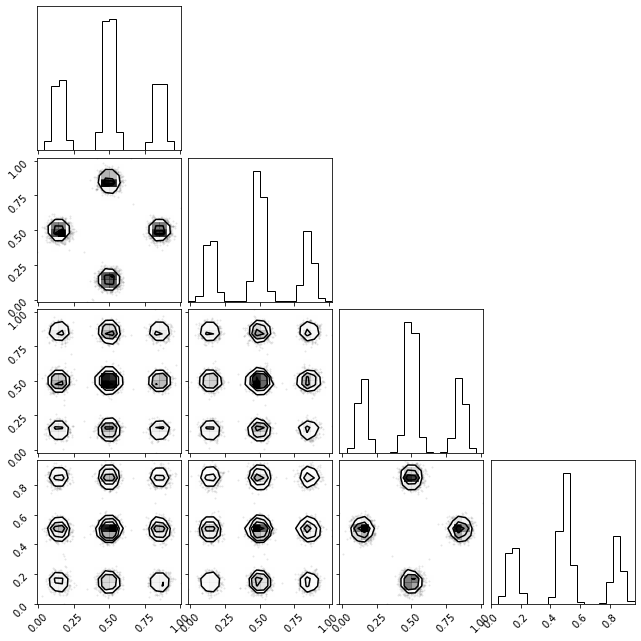

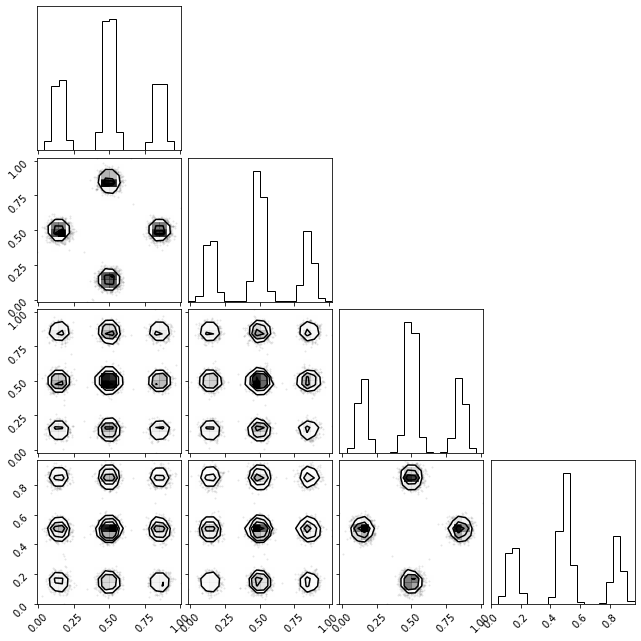

In [216]:
dim=4
s = ps[:, :dim]
center = np.ones(dim) * 0.5

s = s - center[None, :]
m = np.linalg.multi_dot(
    [
        rot4(np.pi/4, 0, 1),
        rot4(np.pi/4, 2, 3),
    ]
)
# m = a
s = np.dot(s, m)
s = s + center[None, :]

print(np.allclose(s, ps[:, :dim]))
corner.corner(s)